### Notebook to check oral androgen deprivation therapy data

A notebook using [English Prescribing Data](https://www.nhsbsa.nhs.uk/prescription-data/prescribing-data/english-prescribing-data-epd) to compare codelists used by OpenPrescribing measure against study findings.

- [Imports](#IMPORTS)
- [Standard functions](#FUNCTIONS)
- [OpenPrescribing BNF codes](#OPBNF)
- [Item / quantity plots](#CHARTS)
- [Injections of different durations](#INJDURATION)

<a id='IMPORTS'></a>
### Imports
Import libraries required for analysis

In [137]:
#import libraries required for analysis
from ebmdatalab import bq
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#set to display all rows in data
#pd.set_option('display.max_rows', None)

<a id='FUNCTIONS'></a>
### Standard functions
Setup standard functions

In [116]:
def plot(df, column_to_plot, chart_title, y_label, y_min='default', y_max='default', lockdownline=False):
    ax = df.groupby(["month"])[column_to_plot].sum().plot(kind='line', title=chart_title)
    plt.xticks(rotation=90);
    plt.ylabel(y_label);
    if (y_min!='default'):
        plt.ylim((y_min, y_max));
    else:
        y_max=df[column_to_plot].max() * 1.05
    if (lockdownline):
        plt.vlines(x=[pd.to_datetime("2020-03-23")], ymin=0, ymax=int(y_max), colors="red", ls="--", label="Start of restrictions");
    plt.grid();

<a id='OPBNF'></a>
### OpenPrescribing BNF codes
Get [English Prescribing Data](https://www.nhsbsa.nhs.uk/prescription-data/prescribing-data/english-prescribing-data-epd) for monthly items and quantity for BNF codes from codelists:
- [Oral ADT](https://www.opencodelists.org/codelist/user/agleman/oral-adt-prostate-ca-dmd/1e2a36a0/)
- [Injectable ADT](https://www.opencodelists.org/codelist/user/agleman/adt-injectable-dmd/20f9318d/)


In [144]:
#OpenPrescribing BNF codes
sql = '''
SELECT
     CAST(month AS DATE) AS month,
     SUM (CASE WHEN bnf_code IN ("0803042A0AAAAAA", "0803042A0AAABAB", "0803042A0AAACAC", "0803042A0AAADAD", "0803042A0BBAAAA",
                                 "0803042A0BBABAB", "0803042E0AAAAAA", "0803042E0AAABAB", "0803042E0AAADAD", "0803042E0AAAEAE", 
                                 "0803042E0AAAFAF", "0803042E0AAAHAH", "0803042E0AAAIAI", "0803042E0BBAAAA", "0803042E0BBABAB", 
                                 "0803042H0AAAAAA", "0803042H0BBAAAA", "0803042H0BCAAAA")  THEN items ELSE 0 END) as OralADTitems,
     SUM (CASE WHEN bnf_code IN ("0803042A0AAAAAA", "0803042A0AAABAB", "0803042A0AAACAC", "0803042A0AAADAD", "0803042A0BBAAAA",
                                 "0803042A0BBABAB", "0803042E0AAAAAA", "0803042E0AAABAB", "0803042E0AAADAD", "0803042E0AAAEAE", 
                                 "0803042E0AAAFAF", "0803042E0AAAHAH", "0803042E0AAAIAI", "0803042E0BBAAAA", "0803042E0BBABAB", 
                                 "0803042H0AAAAAA", "0803042H0BBAAAA", "0803042H0BCAAAA")  THEN quantity ELSE 0 END) as OralADTqty,
     SUM (CASE WHEN bnf_code IN ("0803042B0AAAAAA", "0803042B0BBAAAA", "0803042K0AAAAAA", "0803042K0AAABAB", "0803042K0BBAAAA", 
                                 "0803042K0BBABAB", "0803042K0BCAAAA", "0803042N0AAAAAA", "0803042N0AAABAB", "0803042N0AAACAC", 
                                 "0803042N0AAADAD", "0803042N0AAAEAE", "0803042N0AAAFAF", "0803042N0BBAAAA", "0803042N0BBABAB", 
                                 "0803042N0BBACAC", "0803042N0BBADAD", "0803042N0BCAAAA", "0803042N0BCABAE", "0803042N0BDAAAF", 
                                 "0803042P0AAAAAA", "0803042P0AAABAB", "0803042P0BBAAAA", "0803042P0BCAAAB", "0803042R0AAAAAA", 
                                 "0803042R0AAABAB", "0803042R0BBAAAA", "0803042R0BBABAB", "0803042S0AAABAB", "0803042S0BCAAAB", 
                                 "0803042W0AAAAAA", "0803042W0BBAAAA")  THEN items ELSE 0 END) as InjADTitems,
     SUM (CASE WHEN bnf_code IN ("0803042B0AAAAAA", "0803042B0BBAAAA", "0803042K0AAAAAA", "0803042K0AAABAB", "0803042K0BBAAAA", 
                                 "0803042K0BBABAB", "0803042K0BCAAAA", "0803042N0AAAAAA", "0803042N0AAABAB", "0803042N0AAACAC", 
                                 "0803042N0AAADAD", "0803042N0AAAEAE", "0803042N0AAAFAF", "0803042N0BBAAAA", "0803042N0BBABAB", 
                                 "0803042N0BBACAC", "0803042N0BBADAD", "0803042N0BCAAAA", "0803042N0BCABAE", "0803042N0BDAAAF", 
                                 "0803042P0AAAAAA", "0803042P0AAABAB", "0803042P0BBAAAA", "0803042P0BCAAAB", "0803042R0AAAAAA", 
                                 "0803042R0AAABAB", "0803042R0BBAAAA", "0803042R0BBABAB", "0803042S0AAABAB", "0803042S0BCAAAB", 
                                 "0803042W0AAAAAA", "0803042W0BBAAAA")  THEN quantity ELSE 0 END) as InjADTqty,
 FROM hscic.normalised_prescribing
 WHERE month >= '2015-01-01'
 GROUP BY month
 ORDER BY month'''

OP_DF = bq.cached_read(sql, csv_path=os.path.join('../..','data','OPADT.csv'))

Downloading: 100%|██████████| 92/92 [00:00<00:00, 415.95rows/s]


In [145]:
OP_DF.dtypes

month           datetime64[ns]
OralADTitems             int64
OralADTqty             float64
InjADTitems              int64
InjADTqty              float64
dtype: object

In [146]:
OP_DF['OralADTqty_per_item']=OP_DF['OralADTqty']/OP_DF['OralADTitems']
OP_DF['InjADTqty_per_item']=OP_DF['InjADTqty']/OP_DF['InjADTitems']
OP_DF

month  OralADTitems  OralADTqty  InjADTitems  InjADTqty  \
0  2015-01-01         23465    754252.0        38103    38842.0   
1  2015-02-01         21644    695207.0        33840    34441.0   
2  2015-03-01         24037    764385.0        37629    38299.0   
3  2015-04-01         23155    740084.0        37165    37770.0   
4  2015-05-01         22783    726911.0        36073    36723.0   
5  2015-06-01         23568    753677.0        37364    38050.0   
6  2015-07-01         24730    786592.0        38611    39333.0   
7  2015-08-01         22533    712599.0        35346    35984.0   
8  2015-09-01         23777    753829.0        38084    38811.0   
9  2015-10-01         23962    756810.0        37277    37993.0   
10 2015-11-01         22970    720902.0        36235    36942.0   
11 2015-12-01         25129    795260.0        38393    39092.0   
12 2016-01-01         22461    708175.0        37369    38047.0   
13 2016-02-01         22238    699910.0        35662    36348.0   
14 2016-03-01         23451    735770.0        38314    38978.0   
15 2016-04-01         23438    733929.0        38049    38769.0   
16 2016-05-01         22658    713951.0        36759    37421.0   
17 2016-06-01         23439    735243.0        38087    38833.0   
18 2016-07-01         23037    717577.0        37262    37954.0   
19 2016-08-01         23201    725082.0        37328    37983.0   
20 2016-09-01         23185    729398.0        37887    38582.0   
21 2016-10-01         22634    699398.0        37322    37983.0   
22 2016-11-01         23187    722783.0        37313    38051.0   
23 2016-12-01         23750    735083.0        38041    38701.0   
24 2017-01-01         22376    686438.0        38553    39258.0   
25 2017-02-01         21028    645359.0        35290    35967.0   
26 2017-03-01         23928    733381.0        40559    41338.0   
27 2017-04-01         21597    662580.0        35693    36386.0   
28 2017-05-01         23344    713672.0        38019    38625.0   
29 2017-06-01         23489    720540.0        38963    39704.0   
30 2017-07-01         22618    692191.0        37397    38089.0   
31 2017-08-01         23030    705543.0        38357    39115.0   
32 2017-09-01         22325    681853.0        37262    37975.0   
33 2017-10-01         22548    688556.0        38427    39110.0   
34 2017-11-01         22933    709695.0        38083    38850.0   
35 2017-12-01         23092    716586.0        37142    37784.0   
36 2018-01-01         23157    716204.0        40200    41015.0   
37 2018-02-01         20530    633038.0        35591    36364.0   
38 2018-03-01         22932    711627.0        39240    39989.0   
39 2018-04-01         21626    673598.0        38321    38997.0   
40 2018-05-01         22567    692672.0        39942    40711.0   
41 2018-06-01         22058    674268.0        39152    39870.0   
42 2018-07-01         22548    691567.0        40525    41262.0   
43 2018-08-01         23094    702890.0        40959    41739.0   
44 2018-09-01         21129    642345.0        38358    39081.0   
45 2018-10-01         23016    698496.0        42228    43003.0   
46 2018-11-01         22597    689447.0        40221    41006.0   
47 2018-12-01         22361    682322.0        39514    40163.0   
48 2019-01-01         22686    689817.0        42775    43604.0   
49 2019-02-01         20605    629376.0        37945    38643.0   
50 2019-03-01         21815    667377.0        41137    41838.0   
51 2019-04-01         21570    653276.0        40505    41229.0   
52 2019-05-01         22854    693436.0        42657    43466.0   
53 2019-06-01         21170    641900.0        39332    40089.0   
54 2019-07-01         21854    655936.0        42438    43241.0   
55 2019-08-01         23053    694442.0        41423    42215.0   
56 2019-09-01         21628    653253.0        40485    41267.0   
57 2019-10-01         22937    691166.0        43430    44245.0   
58 2019-11-01         21936    661329.0        40676   

<a id='CHARTS'></a>
### Item/quantity plots

Generate plots from data in above
1. Injectable ADT items dispensed per month - from English Prescribing Dataset
2. Injectable ADT quantity dispensed per month - from English Prescribing Dataset
3. Injectable ADT quantity per item dispensed per month - from English Prescribing Dataset
4. Oral ADT items dispensed per month - from English Prescribing Dataset
5. Oral ADT quantity dispensed per month - from English Prescribing Dataset
6. Oral ADT quantity per item dispensed per month - from English Prescribing Dataset

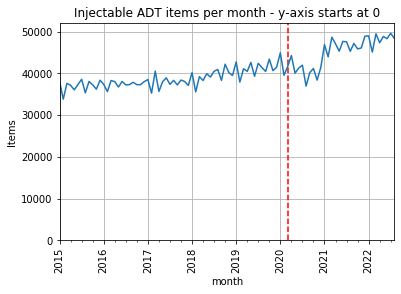

In [147]:
plot(
    df=OP_DF, 
    column_to_plot='InjADTitems', 
    chart_title="Injectable ADT items per month - y-axis starts at 0", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_DF['InjADTitems'].max() * 1.05, 
    lockdownline=True
)

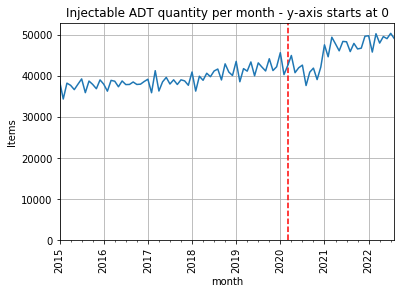

In [148]:
plot(
    df=OP_DF, 
    column_to_plot='InjADTqty', 
    chart_title="Injectable ADT quantity per month - y-axis starts at 0", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_DF['InjADTqty'].max() * 1.05, 
    lockdownline=True
)

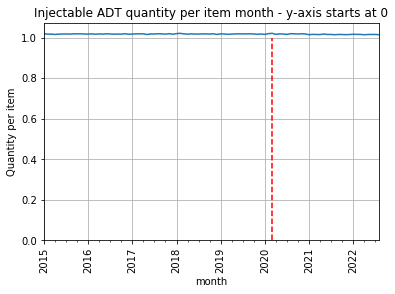

In [150]:
plot(
    df=OP_DF, 
    column_to_plot='InjADTqty_per_item', 
    chart_title="Injectable ADT quantity per item month - y-axis starts at 0", 
    y_label='Quantity per item', 
    y_min=0, 
    y_max=OP_DF['InjADTqty_per_item'].max() * 1.05, 
    lockdownline=True
)

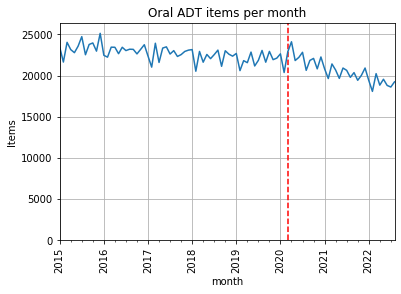

In [151]:
plot(
    df=OP_DF, 
    column_to_plot='OralADTitems', 
    chart_title="Oral ADT items per month", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_DF['OralADTitems'].max() * 1.05, 
    lockdownline=True
)

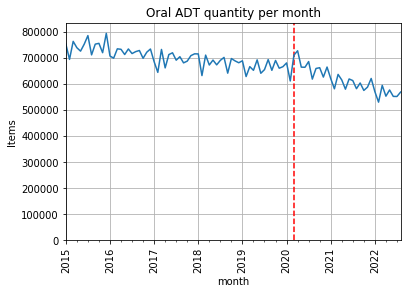

In [152]:
plot(
    df=OP_DF, 
    column_to_plot='OralADTqty', 
    chart_title="Oral ADT quantity per month", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_DF['OralADTqty'].max() * 1.05, 
    lockdownline=True
)

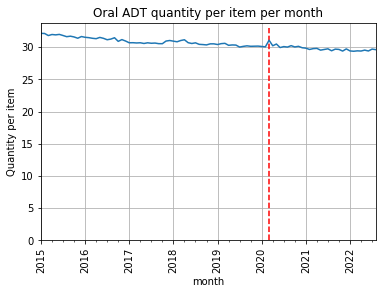

In [153]:
plot(
    df=OP_DF, 
    column_to_plot='OralADTqty_per_item', 
    chart_title="Oral ADT quantity per item per month", 
    y_label='Quantity per item', 
    y_min=0, 
    y_max=OP_DF['OralADTqty_per_item'].max() * 1.05, 
    lockdownline=True
)

<a id='INJDURATION'></a>
### 1 month / 3 month / 6 month injections

Generate plots from data in above
1. Oral ADT items dispensed per month - from English Prescribing Dataset
2. Oral ADT quantity dispensed per month - from English Prescribing Dataset
3. Injectable ADT items dispensed per month - from English Prescribing Dataset
4. Injectable ADT quantity dispensed per month - from English Prescribing Dataset

In [157]:
#OpenPrescribing BNF codes
sql = '''
SELECT
     CAST(month AS DATE) AS month,
     SUM (CASE WHEN bnf_code IN ("0803042K0AAAAAA", "0803042K0BBAAAA", "0803042K0BCAAAA", "0803042N0AAAAAA", "0803042N0AAACAC", 
                                 "0803042N0BBAAAA", "0803042N0BBACAC", "0803042N0BCAAAA", "0803042P0AAAAAA", "0803042P0AAABAB", 
                                 "0803042P0BBAAAA", "0803042P0BCAAAB")  THEN items ELSE 0 END) as monthly,
     SUM (CASE WHEN bnf_code IN ("0803042K0AAABAB", "0803042K0BBABAB", "0803042N0AAABAB", "0803042N0AAADAD", "0803042N0AAAEAE", 
                                 "0803042N0AAAFAF", "0803042N0BBABAB", "0803042N0BBADAD", "0803042N0BCABAE", "0803042N0BDAAAF", 
                                 "0803042P0AAACAC", "0803042P0BBABAC", "0803042S0AAACAC", "0803042W0BBAAAA", "0803042W0AAAAAA")  THEN items ELSE 0 END) as three_monthly,
     SUM (CASE WHEN bnf_code IN ("0803042S0AAABAB", "0803042S0BCAAAB")  THEN items ELSE 0 END) as six_monthly,
     SUM (CASE WHEN bnf_code IN ("0803042B0AAAAAA", "0803042B0BBAAAA", "0803042R0AAAAAA", "0803042R0AAABAB", "0803042R0BBAAAA", 
                                 "0803042R0BBABAB")  THEN items ELSE 0 END) as other,
     
 FROM hscic.normalised_prescribing
 WHERE month >= '2015-01-01'
 GROUP BY month
 ORDER BY month'''

OP_duration = bq.cached_read(sql, csv_path=os.path.join('../..','data','OPinjduration.csv'))
OP_duration

Downloading: 100%|██████████| 92/92 [00:00<00:00, 293.29rows/s]


month  monthly  three_monthly  six_monthly  other
0  2015-01-01    10808          29577          499    891
1  2015-02-01     9516          26259          449    797
2  2015-03-01    10571          29243          557    881
3  2015-04-01    10455          28749          553    895
4  2015-05-01    10272          27888          557    864
5  2015-06-01    10617          28759          567    909
6  2015-07-01    10857          29945          623    978
7  2015-08-01    10121          27179          570    876
8  2015-09-01    10686          29527          647    979
9  2015-10-01    10598          28710          654    949
10 2015-11-01    10262          27906          672    941
11 2015-12-01    11053          29452          723    977
12 2016-01-01    10754          28738          700    930
13 2016-02-01    10433          27325          619    931
14 2016-03-01    11186          29279          712   1002
15 2016-04-01    11136          29060          669   1014
16 2016-05-01    10713          28165          719    945
17 2016-06-01    11174          29095          762   1051
18 2016-07-01    10752          28689          720   1004
19 2016-08-01    10872          28764          670   1052
20 2016-09-01    11154          29068          747   1028
21 2016-10-01    10890          28746          680    997
22 2016-11-01    11077          28425          669   1084
23 2016-12-01    11374          28929          752   1091
24 2017-01-01    11540          29454          749   1056
25 2017-02-01    10907          26513          684    957
26 2017-03-01    12359          30677          814   1172
27 2017-04-01    10821          27124          674   1062
28 2017-05-01    11481          28873          758   1164
29 2017-06-01    11769          29553          744   1210
30 2017-07-01    11474          28319          755   1110
31 2017-08-01    11700          28931          791   1211
32 2017-09-01    11263          28281          752   1191
33 2017-10-01    11637          29228          744   1214
34 2017-11-01    11757          28681          805   1236
35 2017-12-01    11564          27970          765   1224
36 2018-01-01    12554          30278          824   1343
37 2018-02-01    11289          26482          793   1153
38 2018-03-01    12577          29068          804   1326
39 2018-04-01    12041          28655          779   1335
40 2018-05-01    13046          29288          873   1407
41 2018-06-01    12729          28883          808   1350
42 2018-07-01    13273          29938          801   1410
43 2018-08-01    13515          30028          888   1436
44 2018-09-01    12519          28312          836   1307
45 2018-10-01    13834          31146          913   1508
46 2018-11-01    13245          29565          879   1497
47 2018-12-01    13088          28827          843   1430
48 2019-01-01    14103          31607          896   1612
49 2019-02-01    12569          27873          850   1397
50 2019-03-01    13829          30073          882   1547
51 2019-04-01    13433          29777          880   1575
52 2019-05-01    14249          31255          905   1664
53 2019-06-01    12974          28994          850   1530
54 2019-07-01    14305          31111          896   1579
55 2019-08-01    13808          30356          872   1687
56 2019-09-01    13472          29527          904   1680
57 2019-10-01    14513          31652          984   1825
58 2019-11-01    13876          29456          889   1728
59 2019-12-01    14134          29880          970   1744
60 2020-01-01    15311          32732          936   1899
61 2020-02-01    13792          28195          880   1766
62 2020-03-01    14008          30371          946   1823
63 2020-04-01    13949          32795         1200   1975
64 2020-05-01    12813          29771         1076   1721
65 2020-06-01    12931          30928         1118   1828
66 2020-07-01    13311          31263         1043   1888
67 2020-08-01    11818          27477          935   1716
68 202

Plot of GnRH agonists given monthly

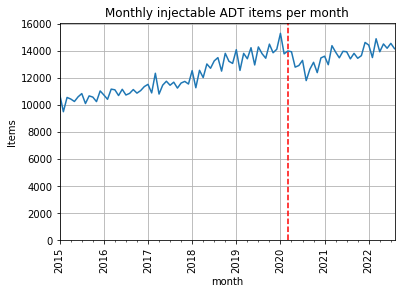

In [127]:
plot(
    df=OP_duration, 
    column_to_plot='monthly', 
    chart_title="Monthly injectable ADT items per month", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_duration['monthly'].max() * 1.05, 
    lockdownline=True
)

Plot of GnRH agonists given 3 monthly

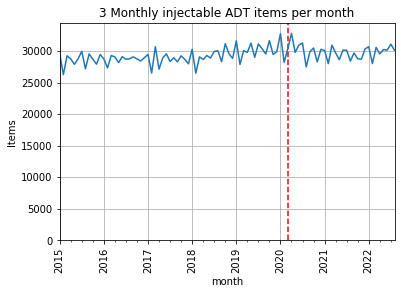

In [128]:
plot(
    df=OP_duration, 
    column_to_plot='three_monthly', 
    chart_title="3 Monthly injectable ADT items per month", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_duration['three_monthly'].max() * 1.05, 
    lockdownline=True
)

Plot of GnRH agonists given 6 monthly

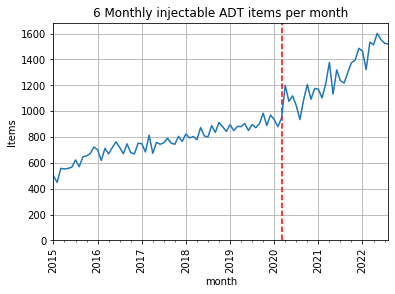

In [129]:
plot(
    df=OP_duration, 
    column_to_plot='six_monthly', 
    chart_title="6 Monthly injectable ADT items per month", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_duration['six_monthly'].max() * 1.05, 
    lockdownline=True
)

Plot of other ADT injections (Degarelix)

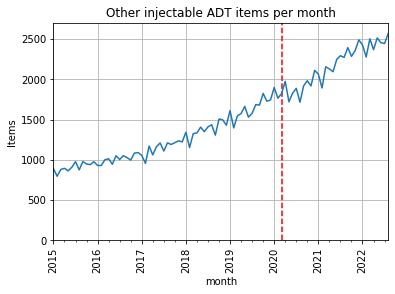

In [165]:
plot(
    df=OP_duration, 
    column_to_plot='other', 
    chart_title="Other injectable ADT items per month", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_duration['other'].max() * 1.05, 
    lockdownline=True
)